In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model, metrics

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)

In [2]:
xls = pd.ExcelFile('data/mental.xlsx')
df = pd.read_excel(xls, 'Data')

In [3]:
# convert low moderate high values to 1 2 3
def _convert(value):
    if value == 'low':
        return 0
    elif value == 'moderate':
        return 1
    elif value == 'high':
        return 2
    elif value == 'unc':
        return np.nan
    else:
        return value

for field in df.columns:
    df[field] = df[field].map(_convert)

# fill in missing values
df = df.fillna(df.mean(numeric_only=True))

In [4]:
# calculate scores
# higher score is better

score_components = [
    'Fear_of_strangers', 'Fear_of_dogs', 'Fear_of_situations', 'Fear', 
    'Aggression_toward_strangers', 'Aggression_toward_owner', 'Aggression', 
    # 'Fear_of_thunder', 'Fear_of_fireworks', 'Fear_of_gunshot', 'Noise_sensitivity', 
    'Fear_of_surfaces_and_heights', 'Destroy_urinate_alone', 'Vocalize_salivate_pant_alone',
    'Separation_related_behaviour', 'Inattention_group',
    'Hyperactivity_impulsivity_group', 'Tail_chasing', 'Fly_snapping',
    'Surface_licking', 'Pacing', 'Staring', 'Excessive_drinking',
    'Self_biting', 'Compulsive_behaviour'
]

# sum over only the selected columns
df["score"] = -df[score_components].sum(axis=1)

env_predictors = ["Age", "Sex", "Sterilisation", "Weaningtime", "Socialization_score", "Family", "Dogs", "Experience", "Daily_exercise", "Activities_training", "Alone", "Urban_environment_score"]
breeds = list(df["Breed"].unique())
# df

# Breed mental wellbeing coefficients, from linear regression

In [5]:
# # perform PCA and ICA on score components
# from sklearn.decomposition import PCA
# from sklearn.decomposition import FastICA

# pca = PCA(n_components=2)
# pca.fit(df[score_components])

# ica = FastICA(n_components=2)
# ica.fit(df[score_components])

# for i, comp_name in enumerate(score_components):
#     # print(f"{comp_name:33} {pca.components_[0][i]:5.2f}  {pca.components_[1][i]:5.2f}")
#     print(f"{comp_name:33} {1000*ica.components_[0][i]:5.2f}  {1000*ica.components_[1][i]:5.2f}")

In [6]:
# one-hot encodings of breeds for linear regression
df2 = pd.concat([df, pd.get_dummies(df["Breed"])], axis=1)

# use linear regression to predict scores
predictors = env_predictors + breeds
# predictors = breeds
# predictors = env_predictors
  
# train the model using the training sets
reg = linear_model.LinearRegression(fit_intercept=False)
reg.fit(df2[predictors], df2["score"])

LinearRegression(fit_intercept=False)

In [7]:
# print wellbeing coefficients for each breed
coefs = []
for predictor, coef in zip(predictors, reg.coef_):
    if predictor in breeds:
        coefs.append((predictor, coef))

avg_wb = np.mean([wb for breed, wb in coefs])

coefs.sort(key=lambda x: x[1])
for breed, wellbeing in coefs:
    print(f"{breed:30} {wellbeing - avg_wb:.2f}")

lhasa apso                     -4.39
miniature_spitz                -3.26
saluki                         -2.47
welsh_springer_spaniel         -2.47
brazilian_terrier              -2.35
pinscher                       -2.10
chinese_crested_dog            -2.09
miniature_pinscher             -2.07
mixed_breed                    -1.98
finnish_hound                  -1.98
japanese_spitz                 -1.97
swedish_vallhund               -1.76
havanese                       -1.71
kooikerhondje                  -1.70
longhaired_miniature_dachshund -1.58
belgian_shepherd_tervueren     -1.37
medium_size_spitz              -1.33
papillon                       -1.29
pomeranian                     -1.20
coton_de_tulear                -1.19
finnish_spitz                  -1.11
belgian_shepherd_groenendael   -1.11
beauceron                      -1.05
parson_russell_terrier         -0.97
chihuahua                      -0.96
tibetan_spaniel                -0.94
schipperke                     -0.90
s

# Get wellbeing of individual dogs, controlled for environment

In [8]:
# fit linear regression on environmental predictors
reg = linear_model.LinearRegression(fit_intercept=True)
reg.fit(df[env_predictors], df["score"])

#  wellbeing scores controlled for environmental predictors
df["env_predicted_score"] = reg.predict(df[env_predictors])
df["mental"] = df["score"] - df["env_predicted_score"]

In [9]:
# _df_stats = df.groupby("Breed").agg({"unexpected_score": ["count", "mean", "std", "sem"], "score": ["mean", "std", "sem"]})
stats = df.groupby("Breed").agg(count=("mental", "size"), mental_mean=("mental", "mean"), mental_std=("mental", "std"), mental_sem=("mental", "sem"))

_popular_dogs = stats.sort_values("count", ascending=False).iloc[:10]
_popular_dogs.sort_values("mental_mean")

,count,mental_mean,mental_std,mental_sem
Breed,,,,
mixed_breed,418,-2.044541,5.760048,0.281733
miniature_schnauzer,255,-0.775744,5.022583,0.314526
german_shepherd,461,-0.494726,5.165040,0.240560
other_breed,1685,-0.320959,5.154401,0.125568
shetland_sheepdog,411,-0.139586,4.673858,0.230544
finnish_lapponian_dog,538,0.507594,4.864781,0.209736
border_collie,268,0.594358,4.914192,0.300182
lapponian_herder,294,0.622301,4.382225,0.255577
wheaten_terrier,351,0.938925,4.642579,0.247803


In [10]:
# find the right bins based on all the data
num_of_bins = 10
_data = df["mental"]
bins = np.linspace(np.min(_data), np.max(_data), num_of_bins)

stats = stats.assign(histogram=None)
for breed, row in stats.iterrows():
    data = df[df["Breed"] == breed]["mental"]
    counts = np.histogram(data, bins=bins)[0]
    counts = counts / np.sum(counts)
    stats.at[breed, "histogram"] = counts

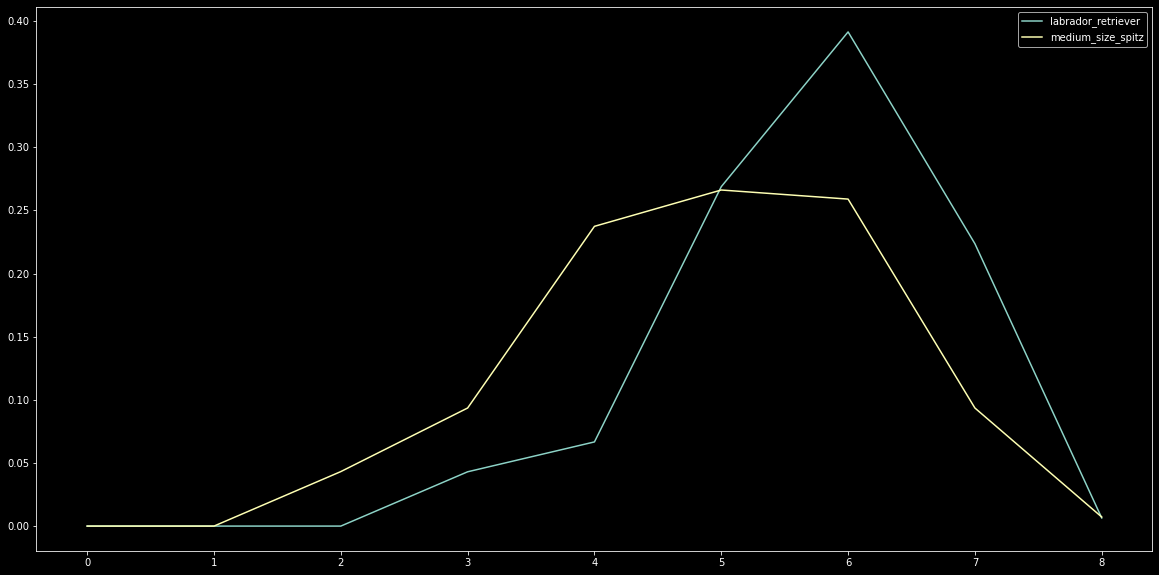

In [11]:
# plot histograms of unexpected scores
plt.figure(figsize=(20, 10))

for breed in ["labrador_retriever", "medium_size_spitz"]:
    hist = stats.loc[breed, "histogram"]
    plt.plot(hist, label=breed)
plt.legend(loc='upper right')

# Analyze physical health data

In [12]:
xls = pd.ExcelFile('data/physical.xlsx')
df_physical = pd.read_excel(xls, 'All_Dogs')

In [13]:
# drop rows where morbidity is nan
df_physical = df_physical.dropna(subset=["Morbidity (Dog Years at Risk)"])

# normalize breed names to snake_case
df_physical["Breed"] = df_physical["Breed"].str.lower().replace(" ", "_", regex=True)

# index by breed
df_physical = df_physical.set_index("Breed")

# sort by morbidity
# df_physical.sort_values("Morbidity (Dog Years at Risk)")

In [68]:
breeds_mental = set(df["Breed"].unique())
breeds_physical = set(df_physical.index)

In [14]:
# for each breed in mental, give a corresponding breed in physical
name_map = {
    "american_akita": "akita",
    "belgian_shepherd_groenendael": "belgian_shepherd_dog_-_groenendael",
    "belgian_shepherd_malinois": "belgian_shepherd_dog_-_malinois",
    "belgian_shepherd_tervueren": "belgian_shepherd_dog_-_tervueren",
    "cocker_spaniel": "english_cocker_spaniel",
    "east_siberian_laika": "east-siberian_laika",
    "finnish_lapponian_dog": "finnish_lapphund",
    "german_shepherd": "german_shepherd_dog",
    "german_wirehaired_pointer": "deutsch_drahthaar_-_german_pointers*", 
    "german_shorthaired_pointer": "deutsch_drahthaar_-_german_pointers*", 
    "irish_setter": "irish_(red)_setter",
    "lagotto_romagnolo": "lagotto_romagnolo_-_romagna_water_dog",
    "longhaired_dachshund": "dachshund_-_standard*",
    "wirehaired_dachshund": "dachshund_-_standard*", 
    "longhaired_miniature_dachshund": "dachshund_-_miniature_*", 
    "wirehaired_miniature_dachshund": "dachshund_-_miniature_*",
    "miniature_poodle": "poodle_-_miniature__and_toy(akc_size_standard)*",
    "toy_poodle": "poodle_-_miniature__and_toy(akc_size_standard)*", 
    "standard_poodle": "poodle_-_standard_(akc_size_standard)",
    "medium_size_spitz": "german_spitz",
    "norbottenspets": "norrbottenspitz",
    "pinscher": "german_pinscher",
    "rough_collie": "collie_rough",
    "smooth_collie": "collie_smooth",
    "welsh_corgi_cardigan": "welsh_corgi_cardigan_and_pembroke*",
    "welsh_corgi_pembroke": "welsh_corgi_cardigan_and_pembroke*",
    "wheaten_terrier": "irish_soft_coated_wheaten_terrier",
    "white_swiss_shepherd": "white_swiss_shepherd_dog",
}

In [15]:
# cleanup breed names in mental data
stats = stats.rename(index={"lhasa apso ": "lhasa_apso"})

# get morbidity for each breed in mental dataset
stats["morbidity"] = stats.index \
    .map(lambda b: name_map.get(b, b)) \
    .map(df_physical["Morbidity (Dog Years at Risk)"])

# remove breeds which don't match
stats = stats.dropna()

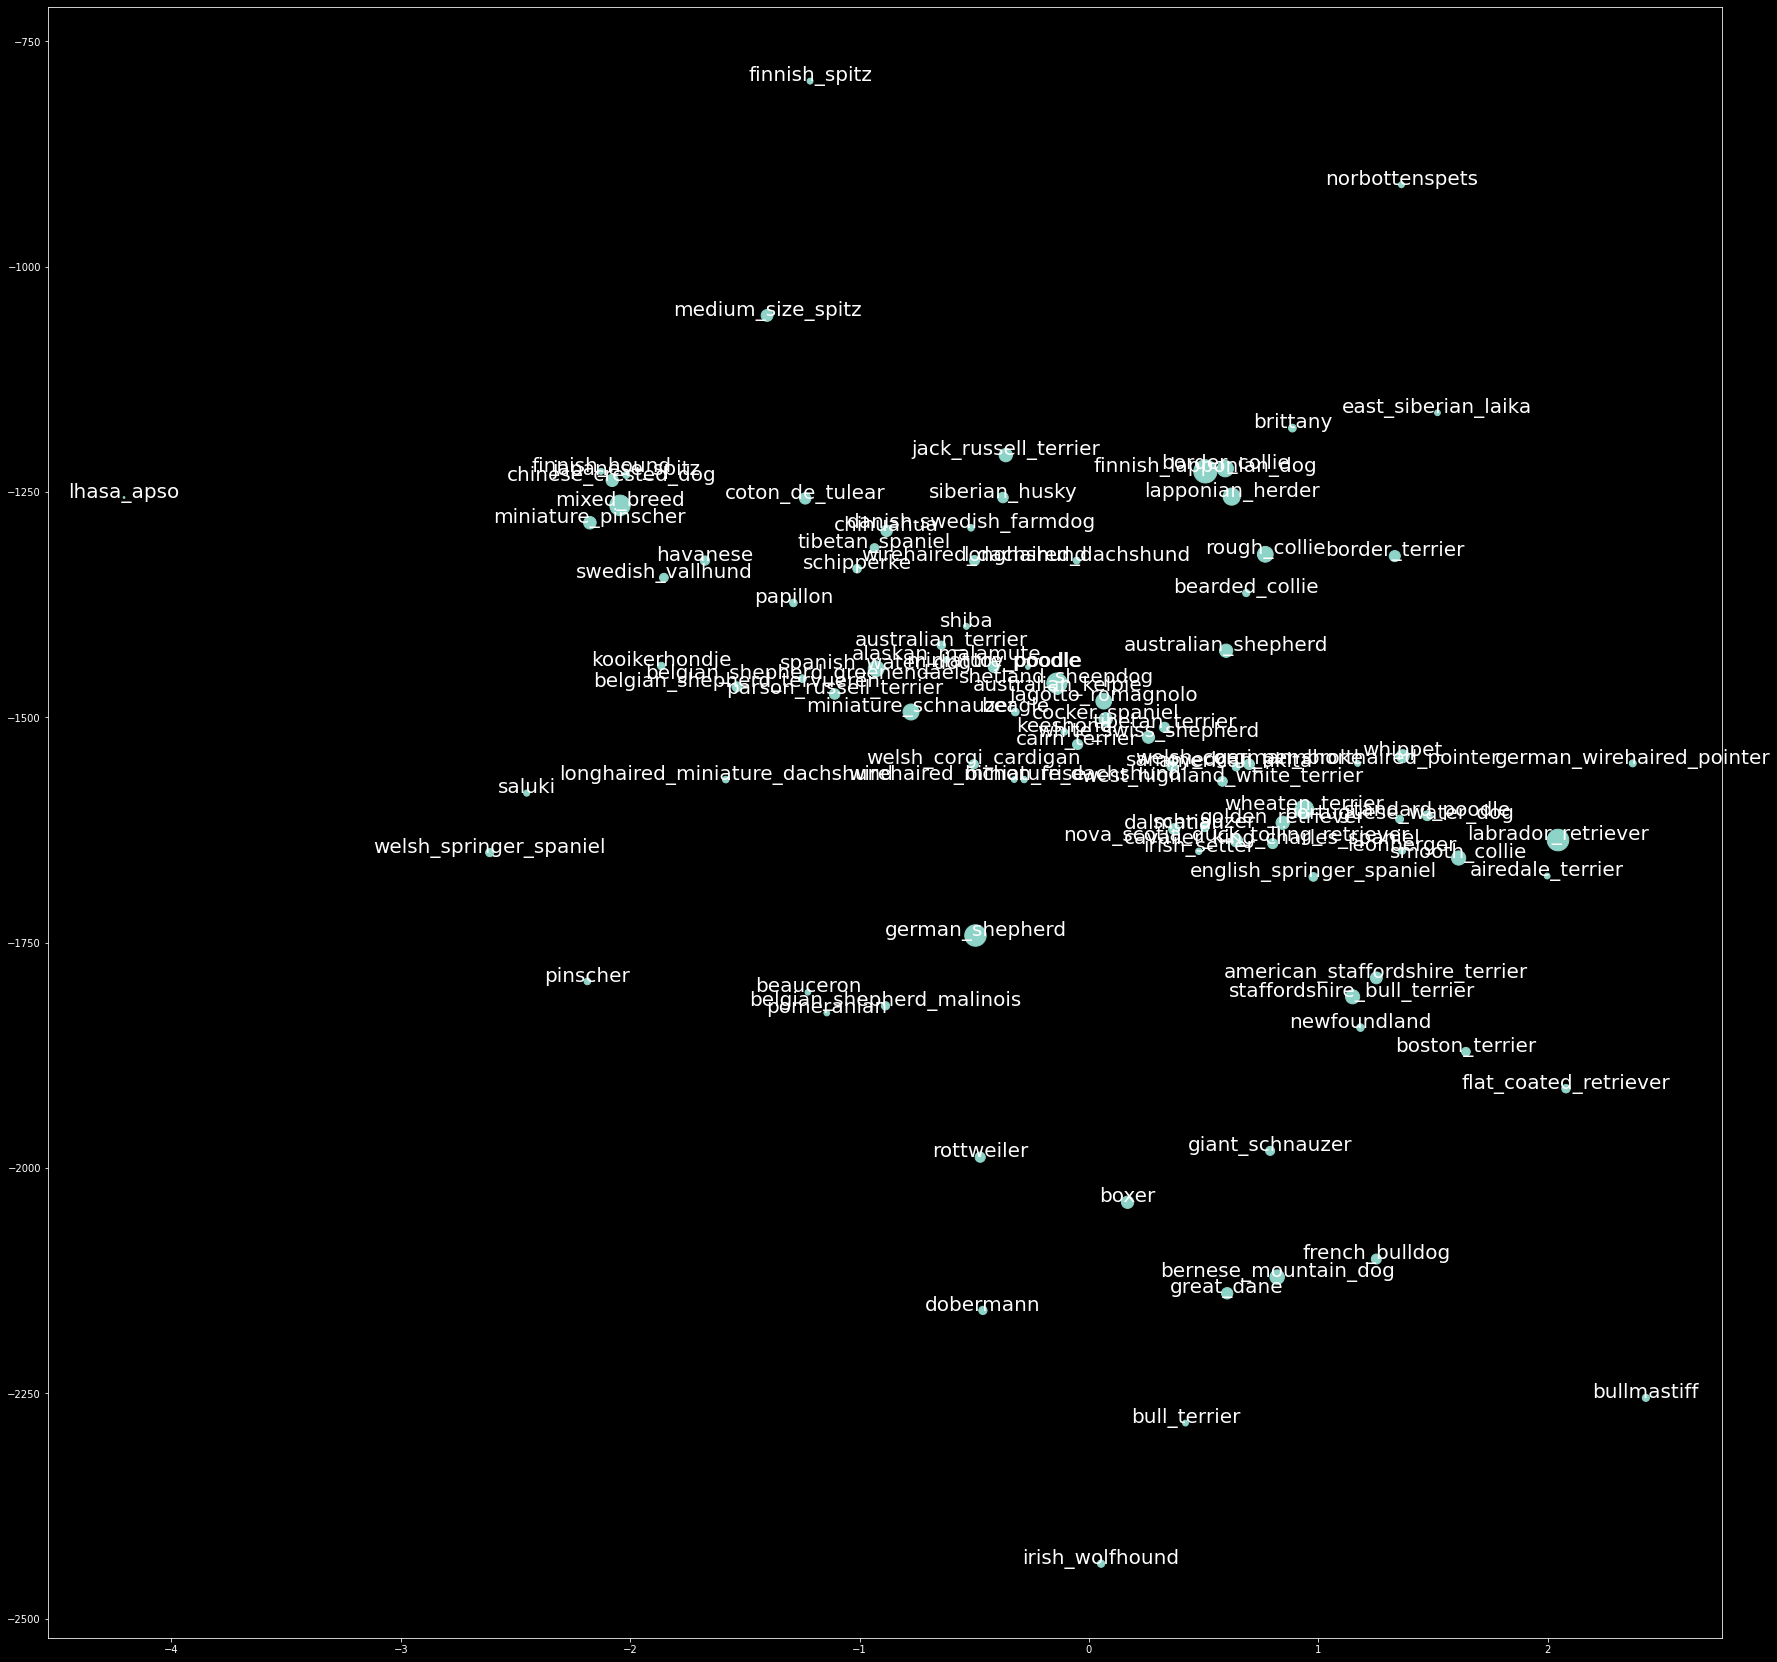

In [17]:
popular = stats.sort_values("count", ascending=False).iloc[:97]

plt.figure(figsize=(30, 30))
plt.scatter(popular["mental_mean"], -popular["morbidity"], s=popular["count"])

for name, x, y in zip(popular.index, popular["mental_mean"], -popular["morbidity"]):
    plt.annotate(name, (x, y), ha="center", size=20)


In [18]:
# save stats to csv
filename = "site/stats.csv"
stats.to_csv(filename)